<img src="https://drive.google.com/thumbnail?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff&sz=w1500" width="500"/>


---


# **Diffusion models**

#### **Morning contents/agenda**

1. *Why* use diffusion models?

2. *What* are diffusion models?

3. Score-based models

#### **Learning outcomes**

1. Understand how Diffusion models differ from VAEs and GANs

2. Understand how the forward and reverse diffusion processes work

3. Understand how we can sample from Diffusion models and the importance of noise in their training

<br>

#### **Afternoon contents/agenda**

1. Implement cosine variance schedule

2. Improve the U-Net architecture

#### **Learning outcomes**

1. Understand the impact of the variance schedule on Diffusion models

2. Understand some of the design choices that make Diffusion models feasible in practice

<br/>

---

<br/>

## 1. *Why* use diffusion models?

### **Concept and motivation**


Many generative modelling techniques, such as [variational autoencoders](https://arxiv.org/abs/1312.6114) (VAEs) and [generative adversarial networks](https://arxiv.org/abs/1406.2661) (GANs), attempt to go directly from a random latent-space sample to a generated output in one forward pass of a network. This is a *very* difficult thing to do for an artificial neural network. It is also a *very* difficult and unnatural thing for a biological neural network to do. For instance, when an author writes a novel, or an artist creates a painting, they do so by gradually refining it over many iterations. Rarely will an author or artist produce their final creation with one train of thought! This observation is the core inspiration behind diffusion models.

Many of the important limitations of VAEs and GANs can be considered a consequence of the aforementioned difficulty in generating data samples with a single network evaluation. VAEs optimise a surrogate loss that is only an *approximation* of maximum likelihood training. This has practical negative consequences on the quality of the generated outputs. Meanwhile, the adversarial training scheme used to optimise GANs is [notoriously unstable](https://arxiv.org/abs/1606.03498). It is also often unfaithful to the true data distribution ([mode collapse](https://arxiv.org/abs/1611.02163)). In truth, the generator doesn't (directly) care about learning a representative model of the data distribution, so long as it can fool the discriminator.

Diffusion models have the potential to circumvent these issues. Diffusion models were first introduced in a [2015 seminal paper](https://proceedings.mlr.press/v37/sohl-dickstein15.html), but they truly became popular in 2019 when [another paper](https://proceedings.neurips.cc/paper_files/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html) showed that these models could rival GANs and VAEs. They benefit from a stable training scheme, and can generate very high quality samples that are competitive with (and now often surpass) those produced using GANs. This is not to say diffusion models are a perfect silver bullet solution, and they certainly have important limitations of their own.

<br/>

>*All models are wrong, but some are useful* - George E. P. Box.

<br/>

A single pass through a diffusion model will likely produce samples that are *“wrong”* and typically much worse than that produced by a VAE or GAN. However, diffusion models are designed to be *“useful”* over many hundreds or thousands of iterations (and network evaluations). A negative consequence of this is that using diffusion models for inference is considerably more computationally expensive than a VAE or GAN, which only require a single pass through the network.

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1t1tgNGszgsaDH076GfF2MC-gS8JW43pD&sz=w1500" width="1000"/>
</center>

<br>

### **The results speak for themselves**

**Imagen**

Developed by Google Research, Brain Team. See paper [here](https://arxiv.org/abs/2205.11487).

In [3]:
from IPython import display
display.IFrame('https://imagen.research.google/', width=1000, height=600)

**Stable diffusion**

Open sourced model and codes [here](https://github.com/CompVis/stable-diffusion).

In [4]:
display.IFrame('https://stablediffusionweb.com/', width=1000, height=600)

**Video Diffusion Models**

Developed by Ho et al. 2022. See paper [here](https://arxiv.org/abs/2204.03458).

In [5]:
display.IFrame('https://video-diffusion.github.io/', width=1000, height=600)

**Open AI's Sora**

In [8]:
display.IFrame("https://openai.com/sora/", width=1000, height=600)

<br/>

---

<br/>

## 2. *What* are diffusion models?

>*Creating noise from data is easy; creating data from noise is generative modeling* -Song et al., 2020

Diffusion models are inspired by non-equilibrium thermodynamics. They define a chain of diffusion steps that slowly add random noise to the data and then learn to reverse the diffusion process in order to generate data samples from noise.

Diffusion models are broadly divided into two complementary steps: forward and reverse diffusion.

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1hYXh0UtXi5Ovv6QjYY97EMksU6LZkvr8&sz=w1500" width="800"/>
</center>

<br>

**Training a Diffusion Model**:
- Forward process: we corrupt our data in a controlled environment (i.e. we know how much noise has been added to the data at each point) - no training is involved

- Training: we train our model to predict the noise contained in a corrupted image at different corruption levels in $[0, T]$

- Reverse process (or sampling): we use our trained network to generate images by **iteratively denoising from pure noise**

<br>

Easy, right? Let's have a look at one step at a time.


### **Forward diffusion**

**NOTE:** *There are a number of different ways to implement Diffusion models, so for the next section we will be using the notation introduced in the [de-noising diffusion probabilistic models (DDPM)](https://arxiv.org/pdf/2006.11239). This is a good baseline from which to understand other types of implementations.*

<br/>

The forward diffusion process begins with a data sample $x(0)$ from our dataset (for example, an image of a dog) and progressively adds noise to it in a step-wise fashion until the sample, $x(T)$, is completely corrupted by noise at step T.

The noise that we add to the data samples is generally sampled from a Gaussian distribution, with a variance schedule that increases progressively from $t = 0$ to $t = T$. The variance schedule is generally designated by $\{ \beta_t \in (0,1) \}_{t=1}^T$.

Given an initial data sample $x(0) = x_0$, we would like to know how to calculate every step in the forward diffusion $x(t) = x_t$ until $x(T) = x_T$. Turns out that, because we are using Gaussian noise, we can use some tricks to arrive at the following expression:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$

Where $\epsilon \sim N(0, 1)$ is a random sample from the normal distribution with zero mean and unit variance, $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{i=1}^t \alpha_i$. This expression will let us easily calculate a noise-corrupted data sample at any step $t$ of the diffusion process.

Let's start implementing this forward diffusion process using the MNIST dataset.

<br/>

We can start by importing some packages:

In [10]:
!pip install pycm livelossplot torchinfo -q
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchvision
from torchvision import transforms

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


And setting up the device:

In [11]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


Now, we can load the MNIST dataset and apply some initial processing to the images:

In [12]:
# Define torch transformations
x_dim = 32
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),                             # Convert to a tensor and normalise to range [0,1]
    transforms.Resize((x_dim, x_dim), antialias=True), # Resize images to 32x32. We will later use this in
                                                       # a U-Net architecture, and inputs with powers of 2
                                                       # are more suitable.
    transforms.Normalize(0.5, 0.5)])                   # Normalise to the range [-1,1]

# Download and define MNIST as a torch dataset, using the above transformations
train_dataset = torchvision.datasets.MNIST("./", download=True, train=True, transform=transform)

# Define a torch dataloader with a batch size of 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.37MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]


We can plot a few samples from the dataset to check that everything is as we expect:

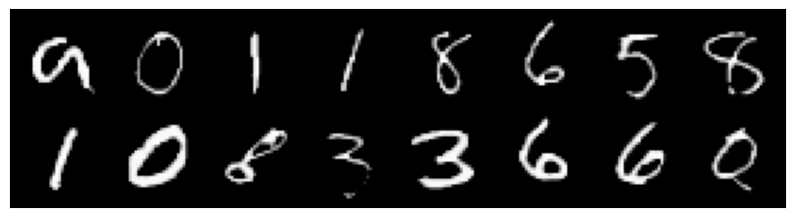

In [13]:
# Grab the first 16 images
x0 = next(iter(train_loader))[0][:16]

# Define a plotting function to visualise the batch as a grid image
def plot_batch(x):
    """plot batch x as grid image"""
    plt.figure(figsize=(10, 10))
    plt.imshow(torchvision.utils.make_grid(x, pad_value=0, padding=2).permute(1, 2, 0))
    plt.xticks([]); plt.yticks([])
    plt.show()

# Visualise the batch
plot_batch(x0)

As we have mentioned, the forward diffusion process is defined by the repeated addition of Gaussian noise to a data sample, $x_0$, according to a pre-defined variance schedule $\beta_{1},\dots ,\beta_{T}$.

<br>

Let's define these variables using the hyperparameters from the original DDPM paper
- $T$ number of timesteps: ``1000``
- $\beta_0$ = ``1e-4``
- $\beta_T$ = ``0.02``
- Linear variance schedule



In [22]:
# Number of variance timesteps
T = 1000

# Define a linear variance schedule
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T) # These are the noise variances added to the sample for every t in [0, T]

betas.shape

torch.Size([1000])

From this schedule, we can calculate other relevant quantities $\alpha_t$ and $\bar\alpha_t$ so we can implement the forward equation defined by:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$

where:

$\alpha_t = 1 - \beta_t$,


$\bar\alpha_t = \prod_{i=1}^t \alpha_i$



In [15]:
# Pre-calculate other helpful terms that derive from the variance schedule
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, axis=0)

alphas.shape, alphas_bar.shape

(torch.Size([1000]), torch.Size([1000]))

Now we can corrupt the data with noise, given the noise schedule, following the forward diffusion process. Let's have a look for a single sample:

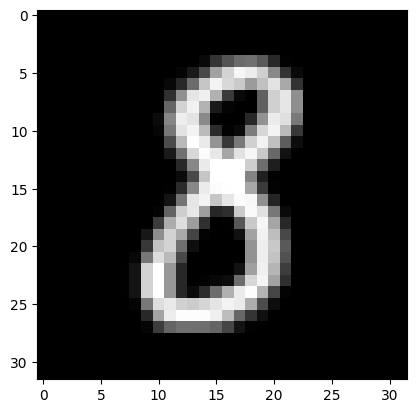

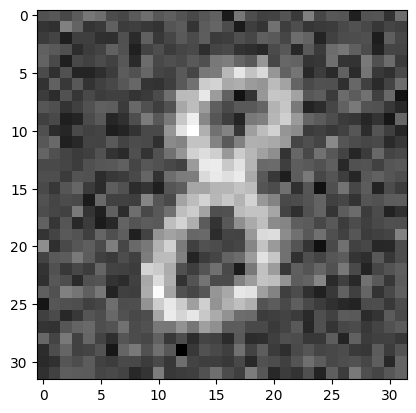

In [16]:
# Grab a single sample for testing
x = next(iter(train_loader))[0][44]

# What does the image look like when corrupted at timestep 't=90' for a noise vector 'e'?
t = 90
e = torch.randn_like(x)

# Forward process
xt = torch.sqrt(alphas_bar[t]) * x + torch.sqrt(1 - alphas_bar[t]) * e

# Plots
plt.imshow(x[0], cmap="gray")
plt.show()

plt.imshow(xt[0], cmap="gray")
plt.show()

What if we want to implement these for an entire batch, each with a different timestep schedule?

Let's write a helper function that retrieves from any scheduling array (betas, alphas, alphas_bar, etc..) the values corresponding to a batch of timesteps:

In [17]:
# Define a helper function that samples any scheduling array (betas, alphas, alphas_bar, etc..)
# for a batch of timesteps t, and expands its dimensionality to that of the data
def fix_batch(sched, t, device):
    """extract scheds for a batch of timesteps t, and expand to batch dimensionality"""
    return sched.to(device)[t.to(device)].view(-1, 1, 1, 1)

# Each sample from the batch will have a different level of noise perturbation so that
# the network does not memorise any individual timestep

# Let's check and understand these dimensions:
t = torch.randint(0, T, (batch_size,))
alphas.shape, t.shape, fix_batch(alphas, t, device).shape

(torch.Size([1000]), torch.Size([64]), torch.Size([64, 1, 1, 1]))

Let's now implement the forward diffusion process, where we take a data sample and progressively corrupt it by adding a sequence of Gaussian noise controlled by the variance schedule:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$

In [18]:
# let's define a function that implements the forward diffusion process
def forward_diffusion(x0, t, e):
    """run the forward diffusion process on x up to time t using noise e"""
    sqrt_alphas_bar = fix_batch(torch.sqrt(alphas_bar), t, x0.device)
    sqrt_alphas_bar_minus_one = fix_batch(torch.sqrt(1. - alphas_bar), t, x0.device)

    return sqrt_alphas_bar*x0 + sqrt_alphas_bar_minus_one*e

Let's test the forward diffusion process out on our current batch $x_{0}$.

**This will be one of the inputs to our network**

tensor([186,  50, 776, 994, 383, 320, 313, 643, 502, 254, 168, 292, 925, 105,
        179, 376])


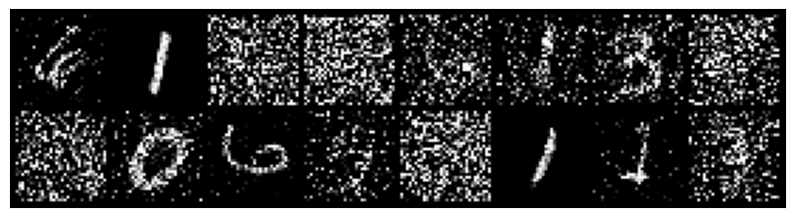

In [19]:
x0 = next(iter(train_loader))[0][:16]

# Sample 16 random values for t
t = torch.randint(0, T-1, (len(x0),))

# Draw a random sample from a normal distribution with unit variance (noise)
e = torch.randn_like(x0)

# Calculate the forward diffusion process for the batch, each corrupted in a level
# defined by t
x_t = forward_diffusion(x0, t, e)

# Plot
print(t)
plot_batch(x_t)

To better understand the forward degradation, we can also check how **one single** image is degraded for a progressively increasing $t$.

**Note that this is for visualisation only, we will not input a single image or an even timestep degradaton into the network at once to avoid it learning any unwanted patterns**

tensor([  0,  66, 133, 199, 266, 333, 399, 466, 532, 599, 666, 732, 799, 865,
        932, 999])


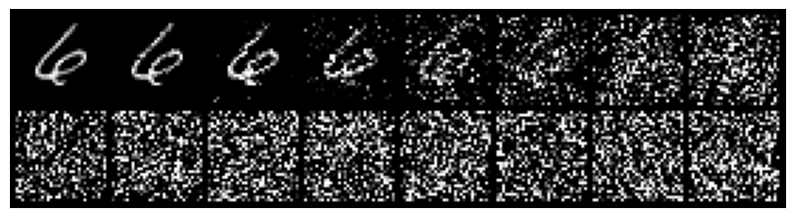

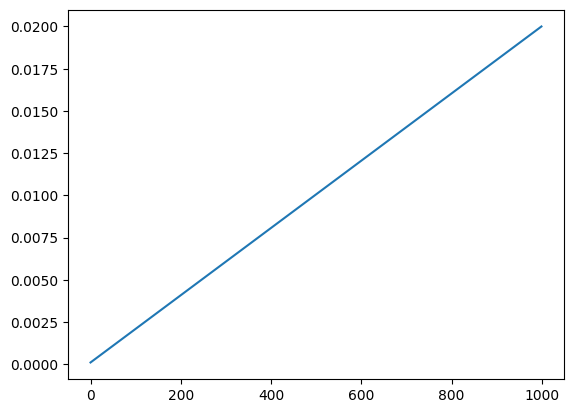

In [27]:
# Sample 16 values for t that are EVENLY SPACED from t=0 to t=T
t = torch.linspace(0, T-1, len(x0), dtype=torch.long)

# draw a random sample from a normal distribution with unit variance
e = torch.randn_like(x0)

# calculate the forward diffusion process for a single image from batch x0
x_t = forward_diffusion(x0[0], t, e)

# Plot
print(t)
plot_batch(x_t)

plt.plot(betas)
plt.show()

Another useful visualisation is the histogram of each of these images at the different timesteps, showing that the forward process slowly degradates the data towards pure Gaussian noise:

/tmp/ipython-input-3592189654.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.hist(x_t[i].flatten(), bins=np.arange(x_t[-1].min(), x_t[-1].max() + 0.5, 0.5), edgecolor='black', linewidth=1.2)


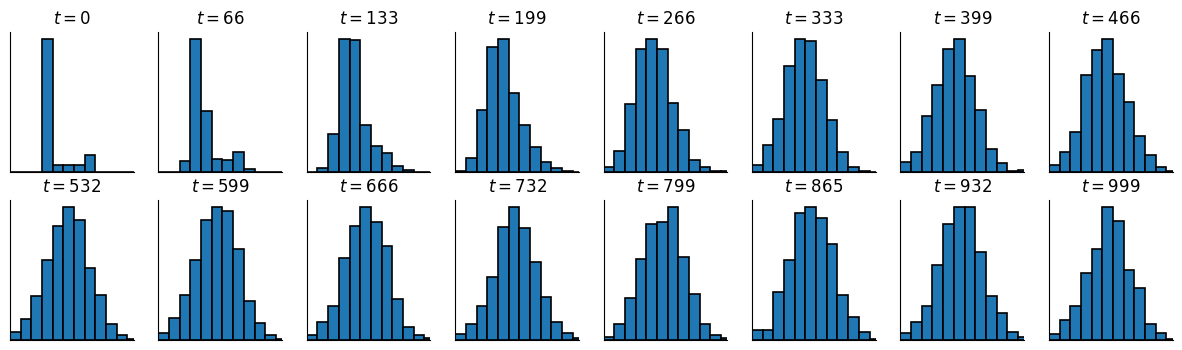

In [15]:
# Display histograms of the pixel values throughout the forward diffusion
plt.figure(figsize=(15, 4))
for i in range(len(t)):
    plt.subplot(2, len(t)//2, 1+i)
    plt.hist(x_t[i].flatten(), bins=np.arange(x_t[-1].min(), x_t[-1].max() + 0.5, 0.5), edgecolor='black', linewidth=1.2)
    plt.xlim(x_t[-1].min(), x_t[-1].max())
    plt.xticks([]); plt.yticks([])
    plt.title(f'$t={t[i]}$')
    sns.despine()

---
---

<br><br><br>

<center>
<img src="https://drive.google.com/thumbnail?id=1hYXh0UtXi5Ovv6QjYY97EMksU6LZkvr8&sz=w1500" width="800"/>
</center>

<br>

### **Training the Diffusion Model**

The reverse diffusion process involves estimating the specific noise patterns that have been introduced at each step and progressively denoising the data from $x(T)$ back to $x(0)$.

The goal of our trained network is to learn how to achieve this denoising process. But, how do we do this? Once again, there are multiple ways of doing this depending on the specific approach used. For now, let's start by considering the [DDPM approach](https://arxiv.org/pdf/2006.11239).

<br/>


We know that the forward diffusion process using Gaussian noise follows this formula:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$

<br>

Where $\epsilon \sim N(0, 1)$ is a random sample from the normal distribution with zero mean and unit variance. The DDPM approach then is to design a neural network that approximates $\epsilon$ at any given step $t$: $\epsilon_\theta(x_t, t)$. We can *easily* train this network by using the MSE loss:

$$
\theta = argmin_\theta ||\epsilon - \epsilon_\theta(x_t, t)||^2
$$

<br/>

It turns out that minimsing this function is also equivalent to minimising the ELBO. For those interested, [this](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) post has a great dissection of the DDPM loss function. (NOT ASSESSED)

<br/>

--> **Inputs to the network are $x_t$ and $t$, the corrupted image and corresponding timestep, respectively**

--> **Output of the network is the prediction of $\epsilon_{\theta} \approx \epsilon$**

Let's create a network and train it on our MNIST dataset then!


<br>

We will use a modified [U-Net](https://arxiv.org/abs/1505.04597) architecture to approximate $\epsilon_{\theta}(x_{t}, t)$.

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1wc5eldR_3yCbjWMwiHQksfiSAtZfhvM5&sz=w1500" width="800"/>
</center>

<br>

A U-Net is composed of the following:
- Convolutional blocks that preserve the size of the images

- Encoding blocks composed of **a few convolutional blocks + a downsampling layer**

- Decoding blocks composed of **an upsampling layer + a few convolutional blocks**, mirroring the encoding blocks

- Residual connections (also known as skip connections) that **transfer information from the encoding blocks to the decoding blocks**

<br>
<br>

Crucially, the U-Net must be conditioned on time $t$, so that it is able to predict the noise $\epsilon$ from a forward diffused image $x_{t}$ at any time from $t=0$ to $t=T$. We will do this by using a concept called **sinusoidal position embeddings**. We will see this concept in more detail in the Transformers lecture.

For now, we only need to understand these embeddings as an **"intelligent" way of representing a single-integer timestep $t$ for the model**. The sinusoidal position embedding takes $t$ as an input, and produces an embedding or vector that represents that particular value of $t$.

In [30]:
# Define the sinusoidal position embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    """sinusoidal position embedding, https://arxiv.org/abs/1706.03762"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # Given a batch of timesteps, create a batch of representative vectors
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

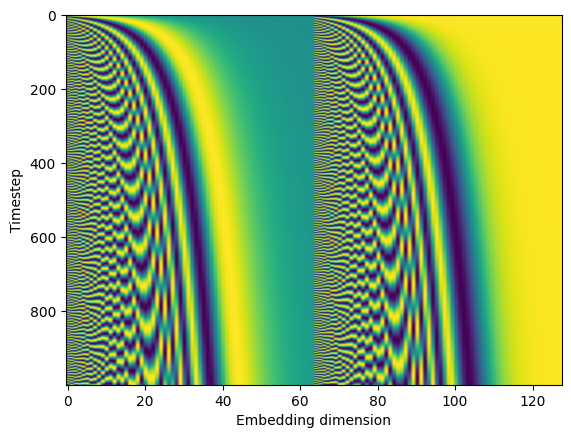

In [47]:
sembed = SinusoidalPositionEmbeddings(x_dim*4)
time_embeds = [sembed(torch.tensor([i])) for i in range(1000)]
time_embeds = torch.stack(time_embeds, dim=0).squeeze(1)

plt.imshow(time_embeds, aspect='auto')
plt.ylabel('Timestep')
plt.xlabel('Embedding dimension')
plt.show()

This embedding is often passed through a small multi-layered perceptron (or fully connected network), and is then added to each convolutional block throughout the U-Net.

In [17]:
# Define a convolutional block with time-embedding
class ConvBlock(nn.Module):
    """time-conditioned convolutional block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.dense = nn.Linear(embed_dim, out_c) # reshapes the time embedding length to the number of channels
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU()

    def forward(self, x, t_embed):
        x = self.conv(x)
        x += self.dense(t_embed)[...,None,None] # add the output of the time embedding dense layer
        x = self.bn(x)
        x = self.act(x)
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):
    """time-conditioned U-Net encoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x, t_embed):
        h = self.conv_block1(x, t_embed)
        h = self.conv_block2(h, t_embed)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):
    """time-conditioned U-Net decoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)

    def forward(self, x, s, t_embed):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h, t_embed)
        h = self.conv_block2(h, t_embed)
        return h

Putting it all together, we can now define our time-conditioned U-Net!

In [18]:
class Unet(nn.Module):
    """DDPM U-Net, https://arxiv.org/abs/2006.11239 and https://arxiv.org/abs/1505.04597"""

    def __init__(self, n_channels, embed_dim):
        super().__init__()

        # time positional embedding MLP
        self.embed = nn.Sequential(SinusoidalPositionEmbeddings(embed_dim),
                                   nn.Linear(embed_dim, embed_dim),
                                   nn.GELU(),
                                   nn.Linear(embed_dim, embed_dim))

        # encoder
        self.e1 = EncBlock(n_channels, 64, embed_dim)
        self.e2 = EncBlock(64, 128, embed_dim)
        self.e3 = EncBlock(128, 256, embed_dim)
        self.e4 = EncBlock(256, 512, embed_dim)

        # bottleneck
        self.b1 = ConvBlock(512, 1024, embed_dim)
        self.b2 = ConvBlock(1024, 1024, embed_dim)

        # decoder
        self.d1 = DecBlock(1024, 512, embed_dim)
        self.d2 = DecBlock(512, 256, embed_dim)
        self.d3 = DecBlock(256, 128, embed_dim)
        self.d4 = DecBlock(128, 64, embed_dim)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x, t):

        t_embed = self.embed(t)

        # encoder
        s1, x = self.e1(x, t_embed)
        s2, x = self.e2(x, t_embed)
        s3, x = self.e3(x, t_embed)
        s4, x = self.e4(x, t_embed)

        # bottleneck
        x = self.b1(x, t_embed)
        x = self.b2(x, t_embed)

        # decoder
        x = self.d1(x, s4, t_embed)
        x = self.d2(x, s3, t_embed)
        x = self.d3(x, s2, t_embed)
        x = self.d4(x, s1, t_embed)

        # output
        output = self.output(x)

        return output

To train the network, we will use the following procedure:

1. Randomly select a sample from the training data $x_{0}$

2. Randomly sample $t$ from a uniform distribution over the range $[1,T]$

3. Randomly sample $\epsilon$ from a zero-mean normal distribution with a variance of 1

4. Apply the forward diffusion process on $x_{0}$ using $\epsilon$ and $t$

5. Predict the noise by evaluating $\epsilon_{\theta}(x_{t}, t)$

6. Calculate the MSE loss between the true noise $\epsilon$ and the predicted noise $\epsilon_{\theta}(x_{t}, t)$

7. Take a gradient descent (or Adam) step with respect to the model parameters $\theta$

8. Repeat steps 1 to 7 until converged

These steps are performed batch-wise in practice.

In [19]:
# define the model and send to the GPU
model = Unet(1, x_dim*4).to(device)

# specify the Adam optimizer with a learning rate of 2e-4
optimiser = torch.optim.Adam(model.parameters(), lr=2e-4)

# set the criterion to be the mse loss
criterion = F.mse_loss

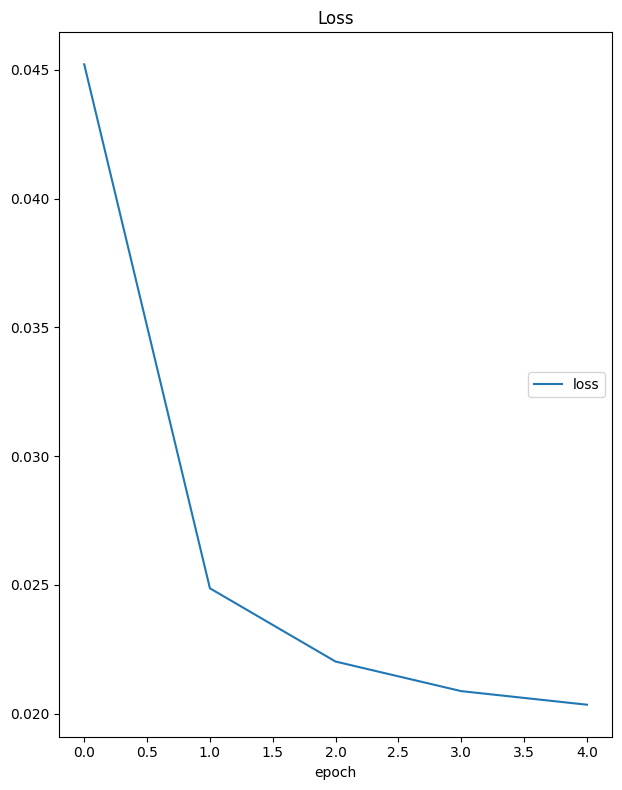

Loss
	loss             	 (min:    0.020, max:    0.045, cur:    0.020)


In [20]:
# Ensure model is in training mode
model.train()

# Set number of epochs and loop over them
n_epoch = 5

# Set up liveloss plot
liveloss = PlotLosses()

for epoch in range(n_epoch):

    # Loop over each batch using tqdm to report progress and loss stats
    # Note that here we're denoting the uncorrupted batch as x0 and that
    # we once again do not care for their labels
    pbar = tqdm(train_loader)
    tot_loss = 0
    logs = {}
    for x0, _ in pbar:

        # Zero the gradients
        optimiser.zero_grad()

        # Send the batch to the GPU
        x0 = x0.to(device)

        # Sample t from a uniform distribution
        t = torch.randint(0, T, (x0.shape[0],), dtype=torch.long).to(x0.device)

        # Sample e from a normal distribution
        e = torch.randn_like(x0)

        # Run the forward diffusion process to add noise to x0
        # The corrupted batch (at various levels of noise) is denoted as xt
        xt = forward_diffusion(x0, t, e)

        # Calculate the loss between the predicted noise and the true noise
        loss = criterion(model(xt, t), e)

        # Backpropagation to obtain gradients w.r.t model parameters
        loss.backward()

        # Report current loss using tqdm
        tot_loss += loss.item()
        pbar.set_description(f"loss: {loss.item():.4f}")

        # Take an optimisation step
        optimiser.step()

    logs['loss'] = tot_loss / len(train_loader)
    liveloss.update(logs)
    liveloss.draw()

In [21]:
# save the model
torch.save(model.state_dict(), 'ddpm.pt')

In [22]:
# load the model
model.load_state_dict(torch.load('ddpm.pt'))

<All keys matched successfully>

### Reverse process: Sampling and Langevin dynamics

Diffusion models are generative models, so the ultimate goal is to learn the underlying probability distribution of our data so that we can generate new samples from it.

If everything has gone well, once our network is trained, we can sample from the learned probability distribution by running the reverse diffusion process.

In theory, once **$\mathbf{\epsilon}$** is known, we could use the forward diffusion process to recover **$x_0$**:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$

But as it turns out, direct sampling of this form is **unstable** (remember GANs?)

<br>
<br>

Instead, we use the concept of **Langevin dynamics**.

Langevin dynamics is a concept from physics, developed for statistically modeling molecular systems. Combined with stochastic gradient descent, stochastic gradient Langevin dynamics can **iteratively** produce samples from a probability density $p(x)$ using gradients of the probability density $\nabla_x \log p(x)$:

$$
x_t = x_{t-1} + \frac{\delta}{2} \nabla_x \log p(x_{t-1}) + \sqrt{\delta} z
$$


Where $z \sim N(0, 1)$, $\delta$ is the step size and as the process converges $t \rightarrow \infty, \epsilon \rightarrow 0$.

<br>

**Can you find the resemblance to stochastic gradient descent?**

<br>

<br>

<center>
<img src="https://yang-song.net/assets/img/score/langevin.gif" alt="network" width="300"/>
</center>

<br>

Given that noise is Gaussian, it is possible to modify this expression to fit the DDPM approach. The result is the following denoising **reverse process**:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar\alpha_t}} \epsilon_\theta(x_t,t) \right) + \sigma_t z
$$

Where $z \sim N(0, 1)$ and $\sigma_t^2 = \beta_t$. If interested, you can find the derivation [here](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

<br/>

**Why is it relevant to add Gaussian noise to the sampling process?**

<br/>

With this in mind, let's implement the reverse diffusion process:

In [23]:
# Let's define a function that implements the reverse diffusion process
def reverse_diffusion(x, t, e, z):
    """run the reverse diffusion process"""
    sigma = fix_batch(torch.sqrt(betas), t, x.device)

    sqrt_recip_alphas = fix_batch(torch.sqrt(1.0 / alphas), t, x.device)

    scale = fix_batch((1 - alphas) / torch.sqrt(1. - alphas_bar), t, x.device)

    return sqrt_recip_alphas * (x - scale*e) + sigma*z

The sampling process then will be:

1. Randomly sample $x_{T}$ from a zero-mean normal distribution with a variance of 1

2. If $t>0$, randomly sample $z$ from a zero-mean normal distribution with a variance of 1, otherwise set $z=0$

3. Calculate the updated sample $x_{t-1}$ by subtracting the predicted noise $\epsilon_{\theta}(x_{t}, t)$ from $x_{t}$

4. Apply $z$, scaled by $\sigma_{t}$, to the sample

5. Repeat steps 2 to 4 for $t=T,\dots,1$

In [24]:
# ensure model is in evaluation mode
model.eval()

# Randomly sample an xT batch from a normal distribution
# We will simply refer to xT as x
x = torch.randn_like(next(iter(train_loader))[0])

# send to the GPU and only consider first 16 of the batch to ease the computational burden
x = x.to(device)[:16]

# Container to store sample throughout the reverse diffusion
diffusion = torch.empty((T, x.shape[0], x.shape[1], x.shape[2], x.shape[3])).to(x.device)

# Context management to ensure gradients are not tracked for any torch tensors or parameters
# since we are only interested in sampling, not training
with torch.no_grad():

    # Loop over time from T to 0
    for t in reversed(range(0,T)):

        # sample z from a normal distribution if condition met
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0

        # visualize samples x every 100 iterations
        if t % 50 == 0:
            print(f'samples at t={t}')
            plot_batch(x.cpu())

        # convert t to a tensor, send to the GPU, and expand its first dimension to be equal to batch size
        t = torch.tensor(t).to(device).expand(x.shape[0])

        # denoise x
        x = reverse_diffusion(x, t, model(x, t), z)

        # clipping to ensure the sample values remain in the range -1 to 1
        x = torch.clamp(x, -1, 1)

        # store the current samples x
        diffusion[t] = x

Output hidden; open in https://colab.research.google.com to view.

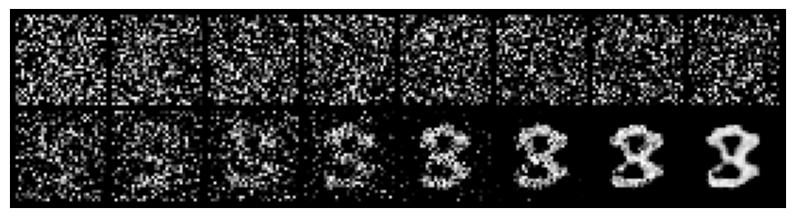

In [25]:
# visualize the diffusion process for a single sample
plot_batch(diffusion[::66,0].flip(0).cpu())

Congratulations, you have implemented and trained a diffusion model!

- Sharper than VAEs
- More stable than GANs
- Downsides? Larger architectural demands + Sampling is no longer one-shot


### **Why add noise?**

A reasonable question at this point is: why are we interested in adding noise to our data samples as part of the diffusion process?

Let's say we have the following data samples in our dataset, which we have used to build our network:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1QdzctWC2-KCEp3Bc1Ti_12-0SvjvjzGj&sz=w1500" width="800"/>
</center>

<br>

The issue here is that in the regions with low density of samples, our network will have an inaccurate model of the probability density function. What happens then if our initial sample for the denoissing process falls in that low-density area?

<br>

<center>
<img src="https://yang-song.net/assets/img/score/pitfalls.jpg" alt="network" width="800"/>
</center>

<br>

Another important issue is that high-dimensional data actually resides on low-dimensional latent manifolds that are embedded in high-dimensional space (see the [manifold hypothesis](https://en.wikipedia.org/wiki/Manifold_hypothesis)). If the data is restricted to a low-dimensional manifold, the gradients of the log-data distribution in the high-dimensional data-space will be undefined.

The solution is to **perturb** the sampled data points with noise. By doing that, we can effectively populate the areas where the probability density function is small:


<br>

<center>
<img src="https://yang-song.net/assets/img/score/multi_scale.jpg" alt="network" width="800"/>
</center>

<br>

### **Or maybe not?**

Research on diffusion modelling is moving fast. Not long ago, [this](https://arxiv.org/pdf/2010.02502) paper reformulated the DDPM framework into a **deterministic mapping**, showing that such approach (**DDIM**) may improve performance of diffusion model sampling by ~10x:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1IBsICmE9CadAD9m9PehAgKzmzeDGkvTe&sz=w1500" alt="network" width="800"/>
</center>

<br>

where $\eta$ are varied levels of stochasticity, and $\hat{\sigma}$ is the original DDPM implementation, all sampled for $\tau=10$ timesteps.




Also, [this](https://arxiv.org/abs/2208.09392) paper demonstrated that *any* image transformation that "degrades" the  quality of a sample can be used to build a diffusion model. This includes transformations that **do not contain any randomness whatsoever**.

This finding represents a significant challenge to our current theoretical understanding of diffusion models, e.g. the theoretical justifications behind DDPMs and SBGMs! According to the semi-official PyTorch DDPM [implementation](https://github.com/lucidrains/denoising-diffusion-pytorch), it "turns out none of the technicalities really matters at all" 💀....

In [26]:
%%html
<iframe src="https://tuananhbui89.github.io/blog/2024/paper-cold-diffusion/" width="1000" height="800">
</iframe>


<br>

### **Why use a U-Net?**

In [27]:
%%html
<iframe src="https://benanne.github.io/2022/01/31/diffusion.html" width="1000" height="800">
</iframe>

<br>

---

<br>

## 3. Score-based models

So far, we have been looking at the DDPM approach to Diffusion models. There is another family of Diffusion models called score-based models (SGM) that take a slightly different approach.

Instead of approximating $\epsilon$, SGM attempts to create a neural network $s_\theta(x)$ that will directly learn how to calculate $s_\theta(x) \approx \nabla_x \log p(x)$ that appears in the Langevin dynamics equation:

$$
x_t = x_{t-1} + \frac{\delta}{2} \nabla_x \log p(x_{t-1}) + \sqrt{\delta} z
$$

For further information on the specifics of how score-based generative models are trained and used, see Yang Song's excellent [blogpost](https://yang-song.net/blog/2021/score/) and [this](https://arxiv.org/abs/2101.03288) tutorial.

<br/>

---

<br/>